In [1]:
import pandas as pd
import numpy as np
import numba
import time
import yfinance as yf
import matplotlib.pyplot as plt
from quantitative_finance.portfolio.portfolio import Portfolio
import dotenv
from eodhd import APIClient
import os

dotenv.load_dotenv(dotenv_path="../.env")

True

In [2]:
api_key = os.environ.get("EODHD_API_KEY")
api = APIClient(api_key)

In [3]:
# Define the ticker symbols
tickers = ["SPY", "EFA", "EEM", "AGG"]
start_date = '2000-01-01'
end_date = '2023-08-01'
frequency = 'd'

In [4]:
price_data = {}
adjusted_close_df = pd.DataFrame()

for idx, ticker in enumerate(tickers):
    response = api.get_eod_historical_stock_market_data(symbol=ticker, period='d', from_date=start_date,
                                                        to_date=end_date, order='a')
    price_df = pd.DataFrame(response)
    price_df['date'] = pd.to_datetime(price_df['date'])
    price_df = price_df.set_index('date')

    if idx == 0:
        adjusted_close_df.index = price_df.index

    adjusted_close_df[ticker] = price_df['adjusted_close'].astype(float)

    price_data[ticker] = pd.DataFrame(response)

In [6]:
total_return_df = adjusted_close_df.pct_change().dropna()

In [7]:
# Generate random weights for each month that sum to 1
np.random.seed(0)  # for reproducibility
number_of_trades = 20
random_weights = np.random.rand(number_of_trades, len(tickers))
random_weights /= random_weights.sum(axis=1)[:, np.newaxis]

weight_dates = np.sort(np.random.choice(total_return_df.index, size=number_of_trades - 1, replace=False))
weight_dates = np.insert(weight_dates, 0, total_return_df.index[0])

# Create a DataFrame for trades with dates as index and tickers as columns
trades = pd.DataFrame(random_weights, columns=tickers, index=weight_dates)

trade_dates = trades.index.to_numpy()
positions = trades.columns.to_numpy()
weights_target_arr = trades.to_numpy()
return_dates = total_return_df[positions].index.to_numpy()
position_returns_arr = total_return_df[positions].to_numpy()

In [8]:
port = Portfolio(
    position_returns=total_return_df[positions],
    positions=positions,
    weights_target=trades,
    return_frequency='D'
)

In [9]:
port.trade_indices_by_position

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}

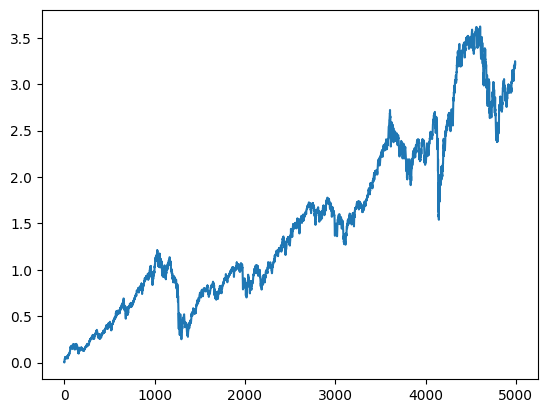

In [39]:
plt.plot(port.backtest.cumulative_performance_arr)

In [6]:
@numba.njit(cache=True)
def calc_cumulative_performance(
        portfolio_returns_arr
):
    log_returns_arr = np.log(portfolio_returns_arr + 1)
    cumulative_performance = np.exp(np.cumsum(log_returns_arr)) - 1
    return cumulative_performance

In [87]:
import numpy as np
import pandas as pd
from typing import Optional, Union, Tuple
from collections import OrderedDict


class PeriodDateCalculator:
    DAYS_OF_YEAR = 365
    MONTHS_OF_YEAR = 12
    QUARTERS_OF_YEAR = 4
    YEARS_OF_YEAR = 1

    def __init__(
            self,
            portfolio_dates: np.ndarray,
            return_frequency: str = 'M',
            fixed_start: bool = False,
            periods: Optional[OrderedDict[str, Optional[float]]] = None
    ):
        """
        Initializes the PeriodDateCalculator with the given portfolio dates and options.

        Args:
            portfolio_dates (np.ndarray): Array of portfolio dates.
            return_frequency (str): Frequency of the return calculation, either 'D' for daily or 'M' for monthly.
            fixed_start (bool): If True, periods will be calculated with a fixed start date. If False, periods will be calculated with a fixed end date.
            periods (Optional[OrderedDict[str, Optional[float]]]): An ordered dictionary of period names and their corresponding lengths in years.
        """
        self.portfolio_dates: pd.DatetimeIndex = pd.to_datetime(portfolio_dates)
        self.return_frequency: str = return_frequency
        self.fixed_start: bool = fixed_start

        if periods is None:
            self.periods = self._default_periods()
        else:
            self.periods = periods

        self.periods_in_year = self._get_periods_in_year()

        if return_frequency not in ['D', 'M', 'Q', 'A']:
            self._return_frequency_error(value=return_frequency)

    def _return_frequency_error(self, value):
        raise ValueError(
            f'"return_frequency" is {value}, which is not a valid value. Please enter "D", "M", "Q", or "A"')

    def _get_periods_in_year(self):
        if self.return_frequency == 'D':
            return self.DAYS_OF_YEAR
        elif self.return_frequency == 'M':
            return self.MONTHS_OF_YEAR
        elif self.return_frequency == 'Q':
            return self.QUARTERS_OF_YEAR
        elif self.return_frequency == 'A':
            return self.YEARS_OF_YEAR
        else:
            self._return_frequency_error(value=self.return_frequency)

    def calc_period_dates(self, periods: Optional[OrderedDict[str, Union[float, None]]] = None) -> OrderedDict[
        str, OrderedDict[str, Union[Tuple[pd.Timestamp, pd.Timestamp], Tuple[int, int]]]]:
        """
        Calculates the start and end dates for various periods based on the portfolio dates.

        Args:
            periods (Optional[OrderedDict[str, Union[float, None]]]): An ordered dictionary of period names and their corresponding lengths in years. If None, default periods will be used.

        Returns:
            OrderedDict[str, OrderedDict[str, Union[Tuple[pd.Timestamp, pd.Timestamp], Tuple[int, int]]]]: An ordered dictionary where keys are period names, and values are dictionaries containing 'Dates' and 'Indices' corresponding to the start and end of the period.
        """
        if periods is None:
            periods = self.periods

        adjusted_periods = self._adjust_periods(periods)
        return self._calculate_period_dates(adjusted_periods)

    def _default_periods(self) -> OrderedDict[str, Optional[float]]:
        """
        Provides the default periods for calculation.

        Returns:
            OrderedDict[str, Optional[float]]: An ordered dictionary of default period names and their lengths in years.
        """
        return OrderedDict([
            ("1M", 1 / 12),
            ("3M", 3 / 12),
            ("6M", 6 / 12),
            ("YTD", None),
            ("1Y", 1),
            ("2Y", 2),
            ("3Y", 3),
            ("5Y", 5),
            ("7Y", 7),
            ("10Y", 10),
            ("15Y", 15),
            ("20Y", 20),
            ("Inception", None)
        ])

    def _adjust_periods(self, periods: OrderedDict[str, Optional[float]]) -> OrderedDict[str, Optional[float]]:
        """
        Adjusts the periods based on the return frequency.

        Args:
            periods (OrderedDict[str, Optional[float]]): An ordered dictionary of period names and their lengths in years.

        Returns:
            OrderedDict[str, Optional[float]]]: An ordered dictionary with periods adjusted to the return frequency (daily or monthly).
        """
        factor = self.periods_in_year
        return OrderedDict((k, v * factor if v is not None else None) for k, v in periods.items())

    def _calculate_period_dates(
            self,
            periods: OrderedDict[str, Optional[float]]
    ) -> OrderedDict[str, OrderedDict[str, Union[Tuple[pd.Timestamp, pd.Timestamp], Tuple[int, int]]]]:
        """
        Calculates the period dates based on the adjusted periods.

        Args:
            periods (OrderedDict[str, Optional[float]]): An ordered dictionary of period names and their lengths, adjusted for the return frequency.

        Returns:
            OrderedDict[str, OrderedDict[str, Union[Tuple[pd.Timestamp, pd.Timestamp], Tuple[int, int]]]]: An ordered dictionary of period names, with calculated start and end dates and their corresponding indices.
        """
        period_dates = OrderedDict()
        start_date = self.portfolio_dates[0]
        end_date = self.portfolio_dates[-1]

        for period_name, adjusted_period_length in periods.items():
            date_offset = self._get_date_offset(adjusted_period_length) if adjusted_period_length is not None else None

            if period_name in ['Inception', 'YTD']:
                if period_name == 'Inception':
                    calculated_start_date = start_date
                else:
                    calculated_start_date = self._find_closest_date_and_index(
                        target_date=pd.Timestamp(f'{end_date.year}-01-01')
                    )[0]
                calculated_end_date = end_date
            else:
                calculated_end_date = start_date + date_offset if self.fixed_start else end_date
                calculated_start_date = end_date - date_offset if not self.fixed_start else start_date

            period_length = (calculated_end_date - calculated_start_date).days / self.DAYS_OF_YEAR

            closest_start_date, start_index = self._find_closest_date_and_index(
                target_date=calculated_start_date
            )
            closest_end_date, end_index = self._find_closest_date_and_index(
                target_date=calculated_end_date
            )

            period_dates[period_name] = OrderedDict([
                ('Dates', (closest_start_date, closest_end_date)),
                ('Indices', (start_index, end_index)),
                ('Number of Years', period_length)
            ])

        return period_dates

    def _find_closest_date_and_index(self, target_date: pd.Timestamp) -> Tuple[pd.Timestamp, int]:
        """
        Finds the closest date in the portfolio dates to the target date and its index.

        Args:
            target_date (pd.Timestamp): The target date to find in the portfolio dates.

        Returns:
            Tuple[pd.Timestamp, int]: The closest date and its index in the portfolio dates.
        """
        closest_date_idx = np.argmin(np.abs(self.portfolio_dates - target_date))
        return self.portfolio_dates[closest_date_idx], closest_date_idx

    def _get_date_offset(self, period_length: Optional[float]) -> pd.DateOffset:
        """
        Generates a date offset based on the period length and return frequency.

        Args:
            period_length (Optional[float]): The length of the period in the appropriate time unit (days or months).

        Returns:
            pd.DateOffset: The calculated date offset.

        Raises:
            ValueError: If the period length is None.
        """
        if period_length is None:
            raise ValueError("Period length cannot be None for calculating start date.")

        offset_int = int(period_length)

        if self.return_frequency == 'D':
            date_offset = pd.DateOffset(days=offset_int)
        elif self.return_frequency == 'M':
            date_offset = pd.DateOffset(months=offset_int)
        elif self.return_frequency == 'Q':
            date_offset = pd.DateOffset(months=3 * offset_int)
        elif self.return_frequency == 'A':
            date_offset = pd.DateOffset(years=offset_int)
        else:
            date_offset = None

        return date_offset


In [88]:
calculator = PeriodDateCalculator(
    total_return_df.index.values,
    return_frequency='D',
    fixed_start=False
)

In [89]:
period_dates = calculator.calc_period_dates()

In [99]:
period_dates['Inception']

OrderedDict([('Dates',
              (Timestamp('2003-09-29 00:00:00'),
               Timestamp('2023-08-01 00:00:00'))),
             ('Indices', (0, 4993)),
             ('Number of Years', 19.852054794520548)])

In [114]:
from numba import njit


def calc_cumulative_returns(
        returns_arr,
        axis=None
):
    return np.exp(np.sum(np.log(returns_arr + 1), axis=axis)) - 1


def calc_rolling_returns(
        rolling_windows
):
    rolling_returns_arr = calc_cumulative_returns(
        returns_arr=rolling_windows,
        axis=2
    )

    return rolling_returns_arr


def calc_rolling_std(
        rolling_windows
):
    rolling_std_arr = np.std(rolling_windows, axis=2)
    return rolling_std_arr


def calculate_var_cvar(returns, confidence_level=0.95):
    """
    Calculate the Value at Risk (VaR) and Conditional Value at Risk (CVaR) of a numpy returns array.

    Parameters:
    returns (numpy array): Array of returns
    confidence_level (float): Confidence level for VaR and CVaR (default is 0.95)

    Returns:
    tuple: (VaR, CVaR)
    """
    # Sort returns
    sorted_returns = np.sort(returns)

    # Calculate the index corresponding to the confidence level
    index = int((1 - confidence_level) * len(sorted_returns))

    # VaR is the value at the given confidence level
    var = sorted_returns[index]

    # CVaR is the average of returns worse than the VaR
    cvar = sorted_returns[:index].mean()

    return var, cvar

In [116]:
def calc_rolling_windows(
        returns_arr,
        window_size,
        periods_dict,
        periods_in_year=None
):
    if periods_in_year is None:
        periods_in_year = 252

    rolling_windows_dict = {k: {} for k in periods_dict.keys()}

    for period_name, period_info_dict in periods_dict.items():
        rolling_windows_dict[period_name]['Rolling Window Length'] = period_info_dict['Number of Years'] * periods_in_year
        rolling_windows_dict[period_name]['Rolling Window'] = np.lib.stride_tricks.sliding_window_view(returns_arr,
                                                                                                       window_shape=window_size,
                                                                                                       axis=0)
    return rolling_windows_dict


In [117]:
window_dict = calc_rolling_windows(
    returns_arr=total_return_df.to_numpy(),
    window_size=252,
    periods_dict=period_dates
)

In [118]:
def calc_rolling_returns_stats(
        window_dict,
):
    rolling_return_dict = {}

    for period_name in window_dict.keys():
        rolling_windows = window_dict[period_name]['Rolling Window']
        rolling_return_dict[period_name] = calc_rolling_returns(
            rolling_windows
        )
    return rolling_return_dict



In [119]:
def calc_rolling_stats(
        window_dict,
        func=calc_rolling_returns
):
    rolling_return_dict = {}

    for period_name in window_dict.keys():
        rolling_windows = window_dict[period_name]['Rolling Window']
        rolling_return_dict[period_name] = func(
            rolling_windows
        )
    return rolling_return_dict

In [122]:
rolling_returns_dict = calc_rolling_stats(
    window_dict=window_dict,
    func=calc_rolling_returns
)

In [123]:
rolling_returns_dict

{'1M': array([[ 0.13126113,  0.21835729,  0.26723704,  0.03913927],
        [ 0.1259139 ,  0.20756298,  0.26494276,  0.03602627],
        [ 0.13614056,  0.22738554,  0.27560349,  0.03218864],
        ...,
        [ 0.15794667,  0.18017375,  0.07311258, -0.02883341],
        [ 0.14578061,  0.17448066,  0.06907993, -0.03455326],
        [ 0.12608504,  0.14392799,  0.06059213, -0.04104202]]),
 '3M': array([[ 0.13126113,  0.21835729,  0.26723704,  0.03913927],
        [ 0.1259139 ,  0.20756298,  0.26494276,  0.03602627],
        [ 0.13614056,  0.22738554,  0.27560349,  0.03218864],
        ...,
        [ 0.15794667,  0.18017375,  0.07311258, -0.02883341],
        [ 0.14578061,  0.17448066,  0.06907993, -0.03455326],
        [ 0.12608504,  0.14392799,  0.06059213, -0.04104202]]),
 '6M': array([[ 0.13126113,  0.21835729,  0.26723704,  0.03913927],
        [ 0.1259139 ,  0.20756298,  0.26494276,  0.03602627],
        [ 0.13614056,  0.22738554,  0.27560349,  0.03218864],
        ...,
        [

In [124]:
rolling_returns_dict = calc_rolling_returns_stats(
    window_dict=window_dict
)
